### Retraining using window of most recent encounters

In [3]:
import os
import random
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import scipy.stats as st
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
from datetime import date, timedelta
import numpy as np, scipy.stats as st

sys.path.append("../..")

from gemini.utils import *
from drift_detector.utils import *
from drift_detector.rolling_window import *
from drift_detector.detector import Detector
from drift_detector.reductor import Reductor
from drift_detector.tester import TSTester, DCTester
from retrainers.mostrecent import MostRecentRetrainer
from baseline_models.temporal.pytorch.optimizer import Optimizer
from baseline_models.temporal.pytorch.utils import *

## Get parameters

In [4]:
PATH = "/mnt/nfs/project/delirium/drift_exp/JULY-04-2022/"
TIMESTEPS = 6
AGGREGATION_TYPE = "time"
HOSPITALS = ["SMH", "MSH", "THPC", "THPM", "UHNTG", "UHNTW", "PMH","SBK"]
OUTCOME = "mortality"
THRESHOLD=0.05
NUM_TIMESTEPS = 6
STAT_WINDOW=30
LOOKUP_WINDOW=0
STRIDE=1

SHIFT = input("Select experiment: ")  # hospital_type
MODEL_PATH = os.path.join(PATH,"saved_models",SHIFT+"_lstm.pt")

if SHIFT == "simulated_deployment":
    exp_params = {
        'source': [datetime.date(2015, 1, 1),datetime.date(2019, 1, 1)],
        'target': [datetime.date(2019, 1, 1), datetime.date(2020, 8, 1)],
        'shift_type': "source_target"
    }
    
if SHIFT == "covid":
    exp_params = {
        'source': [datetime.date(2019, 1, 1), datetime.date(2020, 2, 1)],
        'target': [datetime.date(2020, 3, 1), datetime.date(2020, 8, 1)],
        'shift_type': "time"
    }

if SHIFT == "seasonal_summer":
    exp_params = {
        'source': [1,2,3,4,5,10,11,12],
        'target': [6,7,8,9],
        'shift_type': "month"
    }

if SHIFT == "seasonal_winter":
    exp_params = {
        'source': [3,4,5,6,7,8,9,10],
        'target': [11,12,1,2],
        'shift_type': "month"
    }
    
if SHIFT == "hosp_type_academic":
    exp_params = {
        'source': ACADEMIC, 
        'target': COMMUNITY,
        'shift_type':"hospital_type"
    }

if SHIFT == "hosp_type_community":
    exp_params = {
        'source':COMMUNITY, 
        'target': ACADEMIC,
        'shift_type':"hospital_type"
    }

Select experiment:  simulated_deployment


## Get data

In [5]:
admin_data, x, y = get_gemini_data(PATH)

2022-10-17 11:43:22,422 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggregated_events.parquet


Load data from aggregated events...


2022-10-17 11:43:22,805 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggmeta_start_ts.parquet
2022-10-17 11:43:23,085 INFO cyclops.feature_handler - Loading features from file...
2022-10-17 11:43:23,089 INFO cyclops.feature_handler - Found file to load for static features...
2022-10-17 11:43:23,092 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-10-17 11:43:23,150 INFO cyclops.feature_handler - Found file to load for temporal features...


Load data from feature handler...


2022-10-17 11:43:28,198 INFO cyclops.feature_handler - Successfully loaded temporal features from file...


Load data from admin data...


2022-10-17 11:43:37,298 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggmeta_end_ts.parquet


In [6]:
random.seed(1)

(X_tr, y_tr), (X_val, y_val), (X_t, y_t), feats, admin_data = import_dataset_hospital(admin_data, x, y, SHIFT, OUTCOME, HOSPITALS)

# Normalize data
X_tr_normalized  = normalize(admin_data, X_tr, AGGREGATION_TYPE, TIMESTEPS)
X_val_normalized = normalize(admin_data, X_val, AGGREGATION_TYPE, TIMESTEPS)
X_t_normalized = normalize(admin_data, X_t, AGGREGATION_TYPE, TIMESTEPS)

if AGGREGATION_TYPE != "time":
    y_tr = get_label(admin_data, X_tr, OUTCOME)
    y_val = get_label(admin_data, X_val, OUTCOME)
    y_t = get_label(admin_data, X_t, OUTCOME)
    
# Scale data
X_tr_scaled = scale(X_tr_normalized)
X_val_scaled = scale(X_val_normalized)
X_t_scaled = scale(X_t_normalized)

# Process data
X_tr_final = process(X_tr_scaled, AGGREGATION_TYPE, TIMESTEPS)
X_val_final = process(X_val_scaled, AGGREGATION_TYPE, TIMESTEPS)
X_t_final = process(X_t_scaled, AGGREGATION_TYPE, TIMESTEPS)

## Create data streams

In [7]:
START_DATE = date(2019, 1, 1)
END_DATE = date(2020, 8, 1)

print("Get target data streams...")
data_streams = get_serving_data(
    x, 
    y, 
    admin_data, 
    START_DATE, 
    END_DATE, 
    stride=1, 
    window=1, 
    encounter_id='encounter_id', 
    admit_timestamp='admit_timestamp'
)

Get target data streams...
2019-01-01 - 2019-01-02
2020-01-01 - 2020-01-02


## Get prediction model

In [8]:
retrain="update"
model_name="lstm"
output_dim = 1
input_dim = 108
hidden_dim = 64
layer_dim = 2
dropout = 0.2
last_timestep_only = False
device = get_device()

model_params = {
    "device": device,
    "input_dim": input_dim,
    "hidden_dim": hidden_dim,
    "layer_dim": layer_dim,
    "output_dim": output_dim,
    "dropout_prob": dropout,
    "last_timestep_only": last_timestep_only,
}

model = get_temporal_model(model_name, model_params).to(device)
model, optimizer, n_epochs = load_ckp(MODEL_PATH, model)

# Load model and trainer 
if model_name in ["rnn","gru","lstm"]:
    model = get_temporal_model("lstm", model_params).to(device)
    
    if retrain=="update":
        checkpoint_fpath = os.path.join(PATH,'saved_models',SHIFT+"_lstm.pt")
        model, opt, n_epochs = load_ckp(checkpoint_fpath, model)
        n_epochs = 1
    else:
        n_epochs = 64
        learning_rate = 2e-3
        weight_decay = 1e-6
        loss_fn = nn.BCEWithLogitsLoss(reduction="none")
        optimizer = optim.Adagrad(
            model.parameters(), lr=learning_rate, weight_decay=weight_decay
        )
        lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=128, gamma=0.5)
        activation = nn.Sigmoid()
        opt = Optimizer(
            model=model,
            loss_fn=loss_fn,
            optimizer=optimizer,
            activation=activation,
            lr_scheduler=lr_scheduler,
        )
elif model_name == "gbt":
    with open(model_path, 'rb') as f:
        model = pickle.load(f)    
else:
    print("Unsupported model")

## Get shift detector

In [9]:
DR_TECHNIQUE="BBSDs_trained_LSTM"
MD_TEST="mmd"
SAMPLE=1000
CONTEXT_TYPE="lstm"
PROJ_TYPE="lstm"

print("Get Shift Reductor...")
reductor = Reductor(
    dr_method = DR_TECHNIQUE,
    model_path = MODEL_PATH,
    n_features = len(feats),
    var_ret = 0.8,
)
    
print("Get Shift Tester...")
tester = TSTester(
    tester_method=MD_TEST
)
    
print("Get Shift Detector...")
detector = Detector(
    reductor = reductor,
    tester = tester,
    p_val_threshold = 0.05,
)
detector.fit(X_tr_final)

Get Shift Reductor...
Get Shift Tester...
Get Shift Detector...


2022-10-17 11:48:39.076622: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 11:48:39.183114: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /mnt/nfs/home/subasriv/.cache/pypoetry/virtualenvs/cyclops-KKtuQLwg-py3.9/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:/opt/R/4.0.5/lib/R/lib:/lib:/usr/local/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/java-11-openjdk-amd64/lib/server
2022-10-17 11:48:39.183170: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu

## Retrain

In [ ]:
retrainer = MostRecentRetrainer(
    shift_detector=detector,
    optimizer=optimizer,
    model=model,
    model_name=model_name,
    verbose=True
) 

In [ ]:
all_runs = []
for i in range(0,5):
    random.seed(1)
    
    retrainer.retrain(
        data_streams=data_streams,
        model_path=MODEL_PATH,
        context_type=CONTEXT_TYPE,
        proj_type=PROJ_TYPE, 
    )    
    
    all_runs.append(run_dict)
    mean = np.mean(pvals_test[pvals_test<0.05])
    ci = st.t.interval(0.95, len(pvals_test[pvals_test<0.05])-1, loc=np.mean(pvals_test[pvals_test<0.05]), scale=st.sem(pvals_test[pvals_test<0.05]))
    print(total_alarms, " alarms with avg p-value of ", mean, ci)
    np.save(os.path.join(PATH, shift, shift+"_cumulative_10epochs_retraining_update.npy"), all_runs)

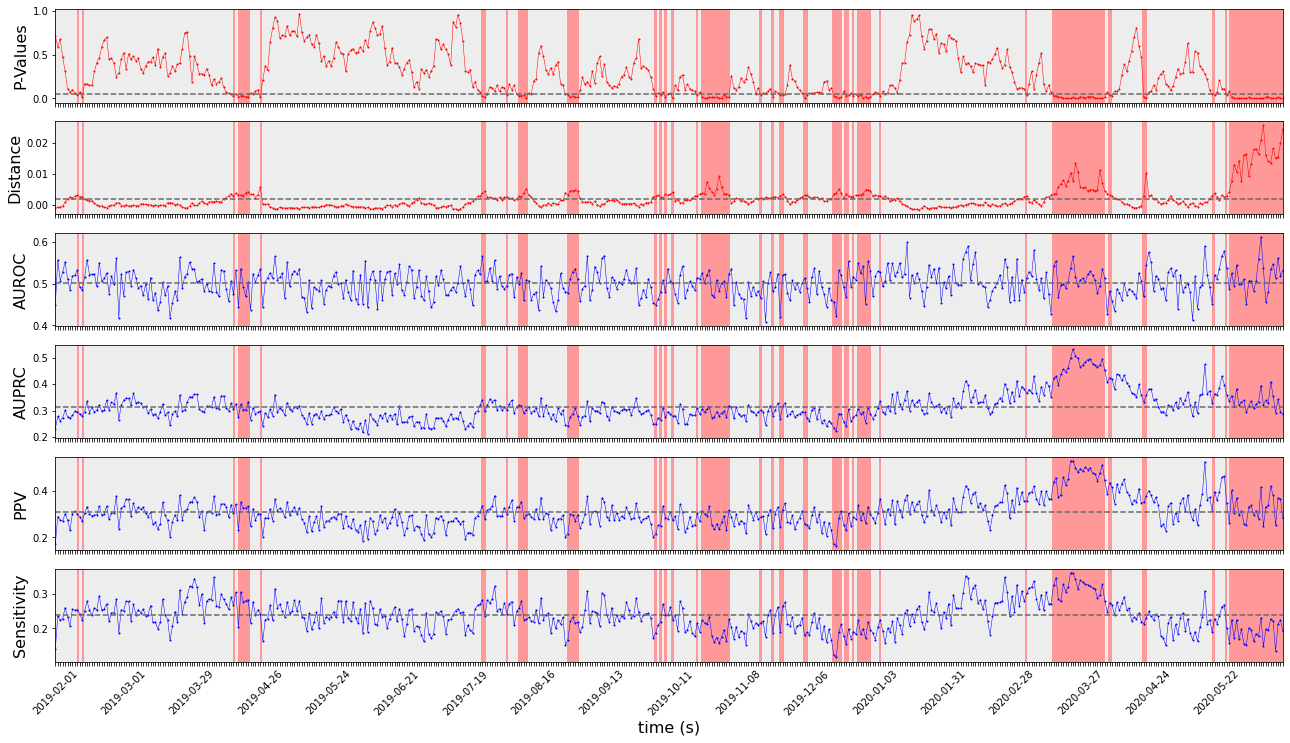

In [9]:
p_val_threshold=0.05
sig_drift = np.array(results['shift_detected'])[np.newaxis]

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(18,12))
cmap = ListedColormap(['lightgrey','red'])
ax1.plot(results['timestamps'], results['p_val'], '.-', color="red", linewidth=0.5, markersize=2)
ax1.set_xlim(results['timestamps'][0], results['timestamps'][-1])
ax1.axhline(y=p_val_threshold, color='dimgrey', linestyle='--')
ax1.set_ylabel('P-Values',fontsize=16)
ax1.set_xticklabels([])
ax1.pcolorfast(ax1.get_xlim(), ax1.get_ylim(),sig_drift, cmap = cmap, alpha = 0.4)
  
ax2.plot(results['timestamps'], results['distance'], '.-',color="red", linewidth=0.5, markersize=2)
ax2.set_xlim(results['timestamps'][0], results['timestamps'][-1])
ax2.set_ylabel('Distance',fontsize=16)
ax2.axhline(y=np.mean(results['distance']), color='dimgrey', linestyle='--')
ax2.set_xticklabels([])
ax2.pcolorfast(ax2.get_xlim(), ax2.get_ylim(),sig_drift, cmap = cmap, alpha = 0.4)

ax3.plot(results['timestamps'], results['auroc'], '.-',color="blue", linewidth=0.5, markersize=2)
ax3.set_xlim(results['timestamps'][0], results['timestamps'][-1])
ax3.set_ylabel('AUROC', fontsize=16)
ax3.axhline(y=np.mean(results['auroc']), color='dimgrey', linestyle='--')
ax3.set_xticklabels([])
ax3.pcolorfast(ax3.get_xlim(), ax3.get_ylim(),sig_drift, cmap = cmap, alpha = 0.4)

ax4.plot(results['timestamps'], results['auprc'], '.-',color="blue", linewidth=0.5, markersize=2)
ax4.set_xlim(results['timestamps'][0], results['timestamps'][-1])
ax4.set_ylabel('AUPRC',fontsize=16)
ax4.axhline(y=np.mean(results['auprc']), color='dimgrey', linestyle='--')
ax4.set_xticklabels([])
ax4.pcolorfast(ax4.get_xlim(), ax4.get_ylim(),sig_drift, cmap = cmap, alpha = 0.4)

ax5.plot(results['timestamps'], results['prec1'], '.-',color="blue", linewidth=0.5, markersize=2)
ax5.set_xlim(results['timestamps'][0], results['timestamps'][-1])
ax5.set_ylabel('PPV', fontsize=16)
ax5.axhline(y=np.mean(results['prec1']), color='dimgrey', linestyle='--')
ax5.set_xticklabels([])
ax5.pcolorfast(ax5.get_xlim(), ax5.get_ylim(),sig_drift, cmap = cmap, alpha = 0.4)

ax6.plot(results['timestamps'], results['rec1'], '.-',color="blue", linewidth=0.5, markersize=2)
ax6.set_xlim(results['timestamps'][0], results['timestamps'][-1])
ax6.set_ylabel('Sensitivity',fontsize=16)
ax6.set_xlabel('time (s)', fontsize=16)
ax6.axhline(y=np.mean(results['rec1']), color='dimgrey', linestyle='--')
ax6.tick_params(axis='x', labelrotation=45)
ax6.pcolorfast(ax6.get_xlim(), ax6.get_ylim(),sig_drift, cmap = cmap, alpha = 0.4)

for index, label in enumerate(ax6.xaxis.get_ticklabels()):
    if index % 28 != 0:
        label.set_visible(False)

plt.show()